In [1]:
import torch
import numpy as np
from tqdm import tqdm
import sys

sys.path.append("../../src")
from explainer import Archipelago
from synthetic_utils import *

sys.path.append("../../baselines/shapley_interaction_index")
from si_explainer import SiExplainer

sys.path.append("../../baselines/shapley_taylor_interaction_index")
from sti_explainer import StiExplainer, subset_before

sys.path.append("../../baselines/mahe_madex/madex")
from utils import general_utils as nid_utils
import neural_interaction_detection as nid

import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

## Parameters

In [3]:
method = "archdetect"
function_id = 4

p = 40 # num features
input_value, base_value = 1, -1

## Get Data and Synthetic Function

In [4]:
input = np.array([input_value]*p)
baseline = np.array([base_value]*p)

print("function id:", function_id)
model = synth_model(function_id, input_value, base_value)
gts = model.get_gts(p)

function id: 4


## Run Baseline Method

In [5]:
if method == "archdetect":
    apgo = Archipelago(model, input=input, baseline=baseline, output_indices=0, batch_size=20) 
    inter_scores = apgo.archdetect()["interactions"]
    
elif method == "si":
    si_method = SiExplainer(model, input=input, baseline=baseline, output_indices=0, batch_size=20, seed=42)

    num_T = 20
    inter_scores = []
    for i in range(p):
        for j in range(i+1, p):
            S = (i,j)
            att = si_method.attribution(S, num_T)
            inter_scores.append( (S, att**2))

elif method == "sti":
    sti_method = StiExplainer(model, input=input, baseline=baseline, output_indices=0, batch_size=20)
    
    inter_atts = sti_method.batch_attribution(num_orderings=20, pairwise=True, seed=42)
    inter_scores = []
    for i in range(p):
        for j in range(i+1, p):
            inter_scores.append( ( (i,j), inter_atts[i,j]**2) )
            
elif method == "nid":
    X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
    Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
    inter_scores, mlp_loss = nid.detect_interactions(Xs, Ys, pairwise=True, seed=42)

elif method == "anova":
    X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
    Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
    X_train = Xs["train"]
    Y_train = Ys["train"]
    
    data =  {}
    data['y'] = Y_train.squeeze()
    st =''
    for i in range(0,X_train.shape[1]):    
        data['X'+str(i)] = X_train[:,i]
        st+='+X'+str(i)
    st = "("+st[1:]+")"
    formula = 'y ~ '+st+":"+st

    lm = ols(formula,data=data).fit()

    table = sm.stats.anova_lm(lm, typ=2)
    inter_scores = []
    for i, name in enumerate(table.index):
        if name == "Residual": continue
        inter = tuple(int(x) for x in name.replace("X", "").split(":"))
        if len(inter)==1: continue

        inter_scores.append((inter, table.values[i,0]))

In [128]:
print("auc", get_auc(inter_scores_my, gts))

auc 0.5


In [7]:
X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
X_train = Xs["train"]
Y_train = Ys["train"]

In [83]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier

lr_f = RandomForestRegressor(random_state=2023, max_depth=10)
lr_f.fit(X_train, Y_train)

/tmp/ipykernel_493501/1181309398.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  lr_f.fit(X_train, Y_train)


RandomForestRegressor(max_depth=10, random_state=2023)

In [10]:
from utilities import *
from visulizer import *
from feature_interaction_helper import *
from feature_importance_helper import *

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [85]:
loss0, bound_f, bound_f_half = find_boundary(Y_train, lr_f.predict(X_train))
loss0

0.1489441778188466

In [70]:
inter_scores, mlp_loss = nid.detect_interactions(Xs, Ys, pairwise=True, seed=42)
mlp_loss

0.00020087721350137144

In [91]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=42,hidden_layer_sizes=800, max_iter=5000).fit(X_train, Y_train)
regr.loss_

/home/sichao/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.00012607054251662892

In [118]:
loss0, bound_f, bound_f_half = find_boundary(Y_train, regr.predict(X_train), 0.005)
vt_f, points_all_max, points_all_min =find_VT(bound_f, loss0, range(len(X_train[-1])), regr, X_train, Y_train)

In [119]:
vt_f

array([[[1.0016, 1.    ],
        [1.0026, 0.999 ],
        [1.0032, 0.9984],
        [1.0037, 0.9979],
        [1.0042, 0.9975],
        [1.0045, 0.9971],
        [1.0049, 0.9967],
        [1.0052, 0.9964],
        [1.0055, 0.9961],
        [1.0058, 0.9958],
        [1.006 , 0.9956]],

       [[1.0125, 1.    ],
        [1.0127, 0.9998],
        [1.0129, 0.9996],
        [1.0131, 0.9994],
        [1.0133, 0.9992],
        [1.0135, 0.999 ],
        [1.0137, 0.9988],
        [1.0138, 0.9987],
        [1.014 , 0.9985],
        [1.0142, 0.9983],
        [1.0144, 0.9981]],

       [[1.0301, 1.    ],
        [1.0303, 0.9998],
        [1.0305, 0.9996],
        [1.0307, 0.9994],
        [1.0309, 0.9993],
        [1.0311, 0.9991],
        [1.0313, 0.9989],
        [1.0315, 0.9987],
        [1.0317, 0.9985],
        [1.0319, 0.9983],
        [1.0321, 0.9981]],

       [[1.    , 0.9844],
        [1.0002, 0.9841],
        [1.0005, 0.9839],
        [1.0007, 0.9836],
        [1.0009, 0.9834],
      

In [116]:
vt_f

array([[[1.0016, 1.    ],
        [1.0019, 0.9998],
        [1.0021, 0.9995],
        [1.0023, 0.9993],
        [1.0024, 0.9992],
        [1.0026, 0.999 ],
        [1.0027, 0.9989],
        [1.0029, 0.9987],
        [1.003 , 0.9986],
        [1.0031, 0.9985],
        [1.0032, 0.9984]],

       [[1.0125, 1.    ],
        [1.0125, 1.    ],
        [1.0125, 1.    ],
        [1.0126, 0.9999],
        [1.0126, 0.9999],
        [1.0127, 0.9998],
        [1.0127, 0.9998],
        [1.0128, 0.9997],
        [1.0128, 0.9997],
        [1.0128, 0.9997],
        [1.0129, 0.9996]],

       [[1.0301, 1.    ],
        [1.0301, 1.    ],
        [1.0302, 1.    ],
        [1.0302, 0.9999],
        [1.0302, 0.9999],
        [1.0303, 0.9998],
        [1.0303, 0.9998],
        [1.0304, 0.9998],
        [1.0304, 0.9997],
        [1.0304, 0.9997],
        [1.0305, 0.9996]],

       [[1.    , 0.9844],
        [1.    , 0.9843],
        [1.0001, 0.9843],
        [1.0001, 0.9842],
        [1.0002, 0.9842],
      

In [120]:
myloss_all_2, diff_all_2 = Interaction_effect_all_pairs(X_train, Y_train, range(40), 2, regr, vt_f, loss0, bound_f, regression=True)


In [121]:
strength, cor, circle, amount = feature_interaction_strength(diff_all_2, myloss_all_2, 2, bound_f, 0, loss0)

In [101]:
amount

2.816958679313555e-13

In [62]:
inter_scores_my

[((0, 1), 0.9854600169772756),
 ((0, 2), 0.8817758477725959),
 ((0, 3), 0.9903801168540753),
 ((0, 4), 0.9917141133103119),
 ((0, 5), 0.9879627281489815),
 ((0, 6), 0.9925770071259554),
 ((0, 7), 0.9556535565714592),
 ((0, 8), 0.9937342580510659),
 ((0, 9), 0.9894783792713023),
 ((0, 10), 0.9843116136132829),
 ((0, 11), 0.9933221945157754),
 ((0, 12), 0.990585665608017),
 ((0, 13), 0.9922526321530761),
 ((0, 14), 0.9778782786810787),
 ((0, 15), 0.9890840920902548),
 ((0, 16), 0.9288566156157682),
 ((0, 17), 0.9828604222094203),
 ((0, 18), 0.9929302502078063),
 ((0, 19), 0.9877210840020737),
 ((0, 20), 0.9917898790409407),
 ((0, 21), 0.9820619419402715),
 ((0, 22), 0.9764779789946769),
 ((0, 23), 0.9892370468915418),
 ((0, 24), 0.9822264830291265),
 ((0, 25), 0.9907845275701703),
 ((0, 26), 0.9691562160865337),
 ((0, 27), 0.9927674589501392),
 ((0, 28), 0.9910857051675802),
 ((0, 29), 0.9933692106590709),
 ((0, 30), 0.9744573959707719),
 ((0, 31), 0.9865954353279617),
 ((0, 32), 0.99253

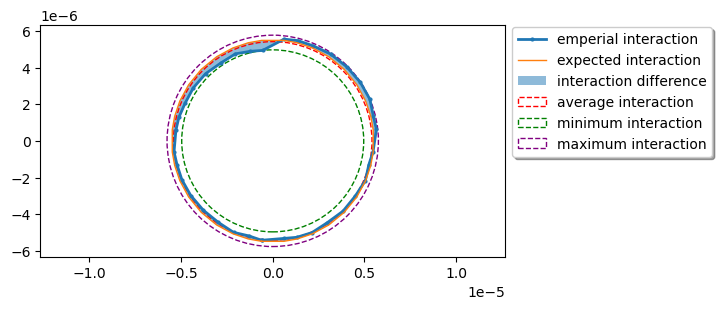

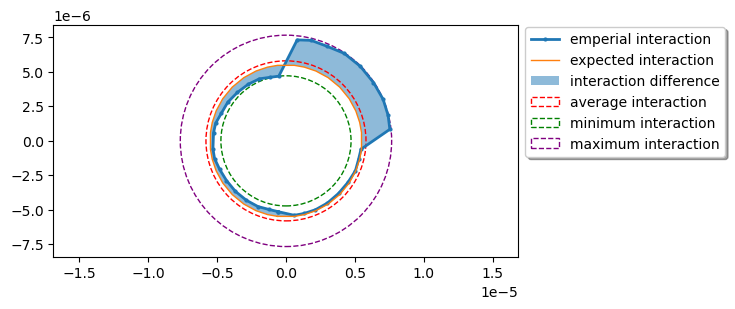

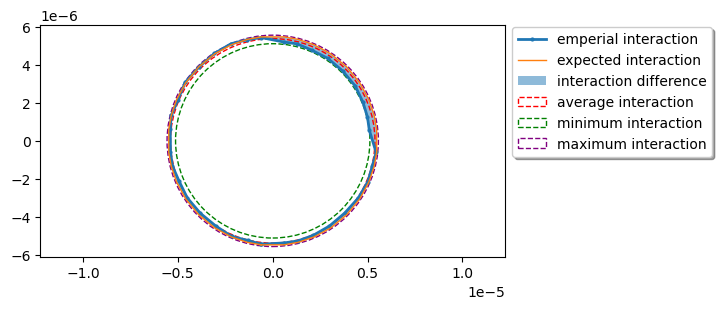

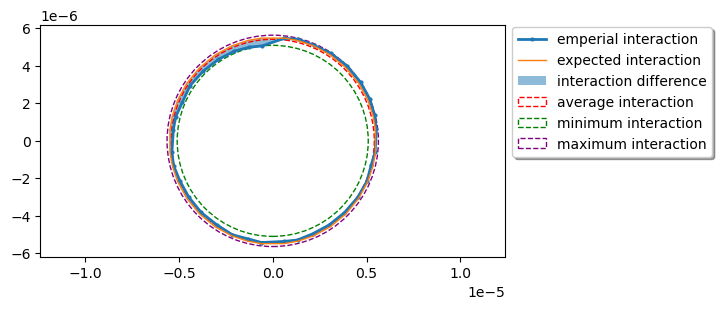

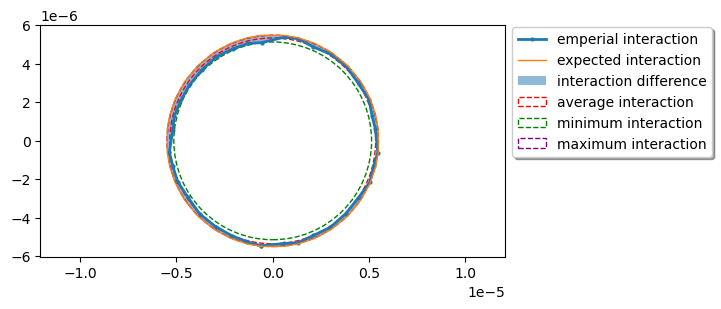

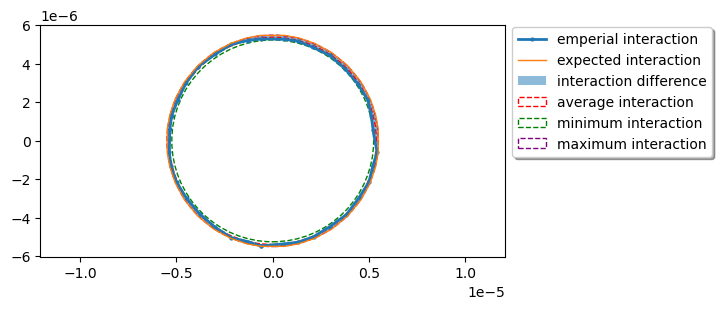

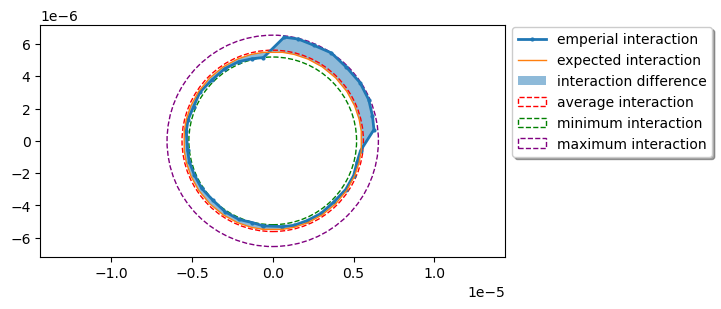

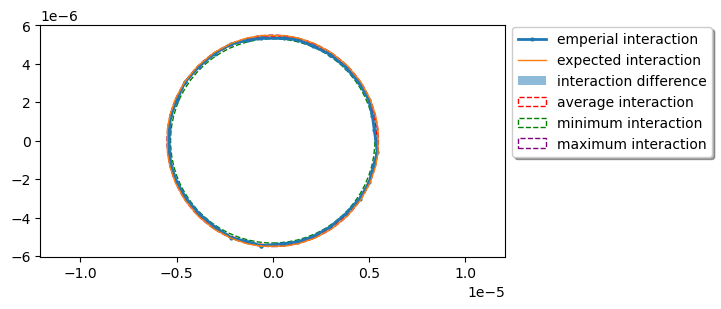

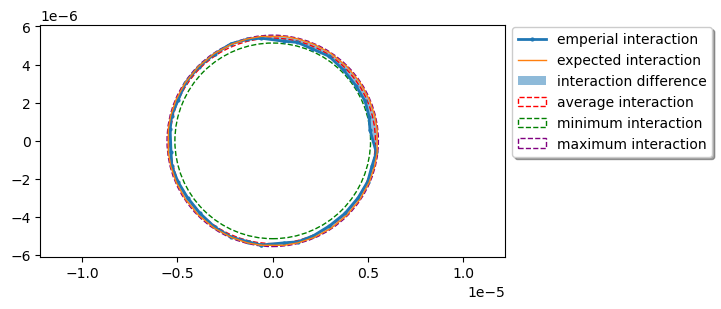

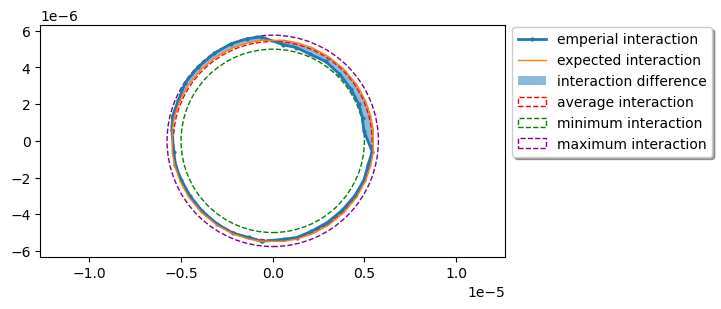

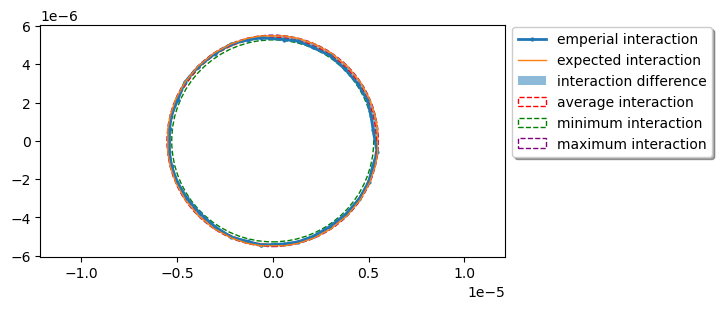

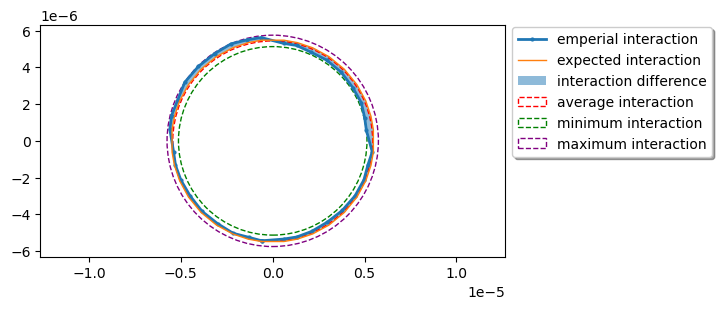

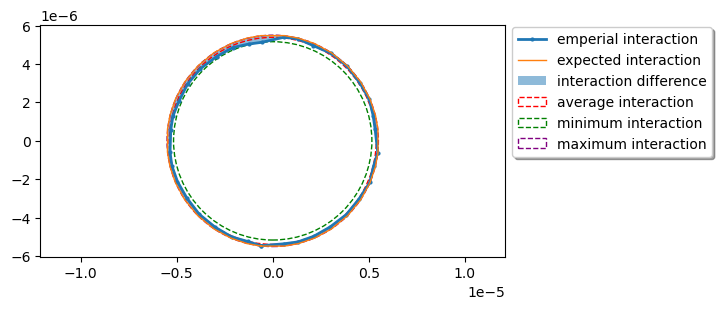

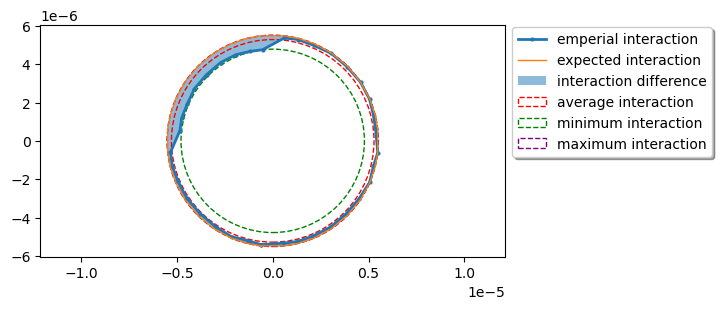

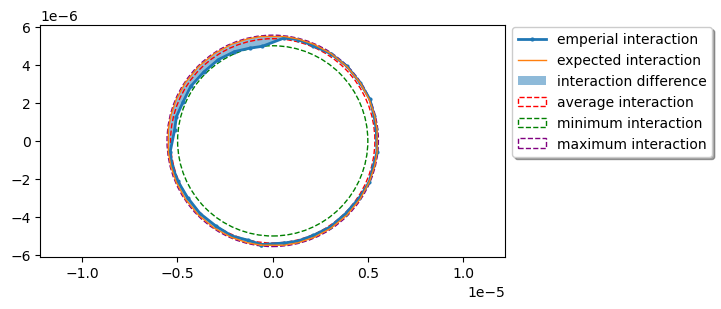

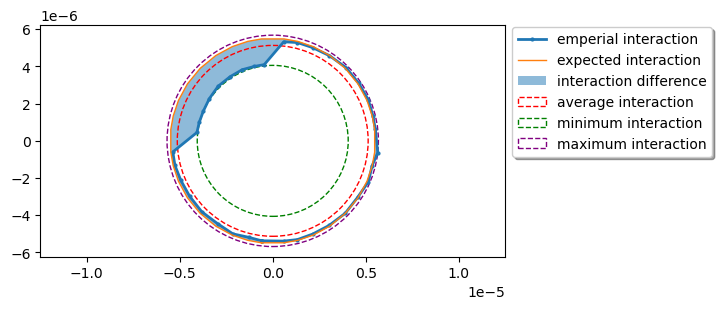

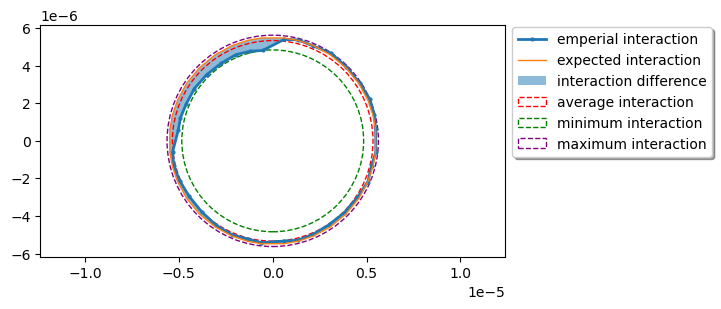

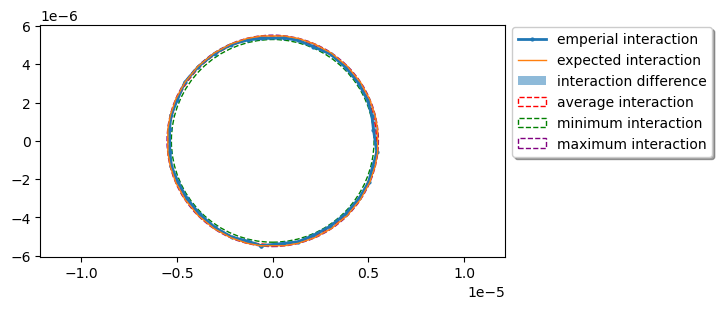

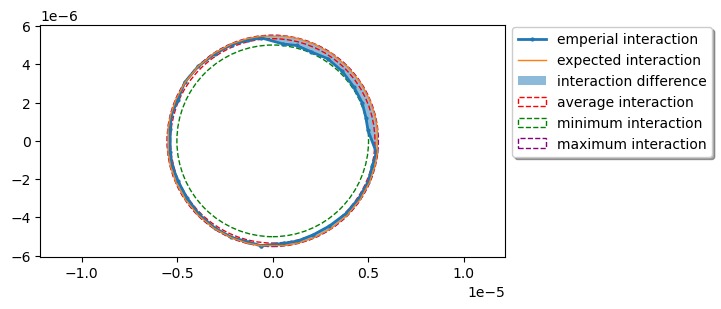

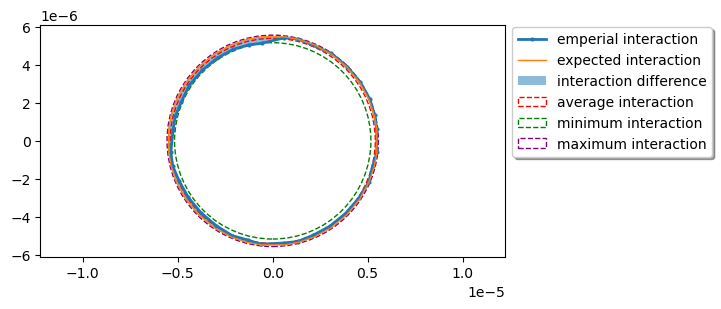

In [61]:
for i in range(20):
    
    strength, cor, circle, amount = feature_interaction_strength(diff_all_2, myloss_all_2, 2, bound_f, i, loss0)
    feature_interaction_vis_2D(circle, cor, bound_f, diff_all_2, i)

In [125]:
print("auc", get_auc(inter_scores_my, gts))

auc 0.5


In [35]:
def feature_interaction_strength(emp_diff, myloss_all, n_ways, boundary, pair_idx, loss0):
    '''
    amount is approximated by the area of a circle - delta*(emp_diff+exp_diff)
    
        Input: 
            emp_diff: calculated difference
            n_ways: number of ways
            boundary: pre-defined boundary
        Output:
            the feature interaction strength
        
    '''    
    top = ((myloss_all - loss0 - boundary)/boundary) ** 2 
    bot = ((myloss_all)/boundary) ** 2 + 2
    strength = np.sum(top/bot, axis=1)
    
    sum_to_one_pairs = find_all_sum_to_one_pairs(n_ways)
#     exp_diff = np.array(sum_to_one_pairs)[:,0]*0.1
    cord = []
    circle = []
    cord_sorted_1 = []
    cord_sorted_2 = []
    cord_sorted_3 = []
    cord_sorted_4 = []
    if n_ways > 2:
        cord_sorted_5 = []
        cord_sorted_6 = []
        cord_sorted_7 = []
        cord_sorted_8 = []
        for idx,pair in enumerate(sum_to_one_pairs): 
            cosa = pair[0]/(np.sqrt(pair[0]**2 + pair[1]**2 + pair[2]**2))
            cosb = pair[1]/(np.sqrt(pair[0]**2 + pair[1]**2 + pair[2]**2))
            cosc = pair[2]/(np.sqrt(pair[0]**2 + pair[1]**2 + pair[2]**2))
            dega = np.arccos(cosa)
            degb = np.arccos(cosb)
            degc = np.arccos(cosc)
#           iterate in 111, 110, 101, 100, 011, 010, 001, 000
            l = [1, -1]
            idx2 = 0
            for d in list(itertools.product(l, repeat=3)):
                dis = boundary + emp_diff[pair_idx][idx*8+idx2]
                cord.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]])
                circle.append([boundary*np.cos(dega)*d[0], boundary*np.cos(degb)*d[1], boundary*np.cos(degc)*d[2]])
                cord_sorted_1.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 0 else None   
                cord_sorted_2.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 1 else None
                cord_sorted_3.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 2 else None                    
                cord_sorted_4.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 3 else None
                cord_sorted_5.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 4 else None   
                cord_sorted_6.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 5 else None
                cord_sorted_7.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 6 else None                    
                cord_sorted_8.append([dis*np.cos(dega)*d[0], dis*np.cos(degb)*d[1], dis*np.cos(degc)*d[2]]) if idx2 == 7 else None
                idx2 = idx2 + 1
#         cord_sorted_1.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_2.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_3.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_4.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_5.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_6.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_7.sort(key=lambda c:(c[0], c[1]))
#         cord_sorted_8.sort(key=lambda c:(c[0], c[1]))
        volumn_total = Integral_Approximation_Double(cord_sorted_1) + Integral_Approximation_Double(cord_sorted_2) + Integral_Approximation_Double(cord_sorted_3) + Integral_Approximation_Double(cord_sorted_4) + Integral_Approximation_Double(cord_sorted_5) + Integral_Approximation_Double(cord_sorted_6) + Integral_Approximation_Double(cord_sorted_7) + Integral_Approximation_Double(cord_sorted_8)
        volumn_ball = (4/3)*np.pi*boundary*boundary*boundary
        volumn_ratio = (volumn_total/volumn_ball)
        return strength, cord, circle, volumn_ratio
    else:
        for idx,pair in enumerate(sum_to_one_pairs):
            deg = (np.arctan2(pair[0], pair[1]))
            for i in range(4):
                dis = boundary + emp_diff[pair_idx][idx*4+i]
                x = dis*np.cos(deg)
                y = dis*np.sin(deg)
                deg = deg+np.pi*.5
                cord.append([x, y])
                circle.append([boundary*np.cos(deg), boundary*np.sin(deg)])
                cord_sorted_1.append([x, y]) if i == 0 else None   
                cord_sorted_2.append([x, y]) if i == 1 else None
                cord_sorted_3.append([x, y]) if i == 2 else None                    
                cord_sorted_4.append([x, y]) if i == 3 else None
                           
        cord_sorted_1.sort(key=lambda c:(c[0]))
        cord_sorted_2.sort(key=lambda c:(c[0]))
        cord_sorted_3.sort(key=lambda c:(c[0]))
        cord_sorted_4.sort(key=lambda c:(c[0]))
        # Integral Approximation
        area_total = Integral_Approximation(cord_sorted_1) + Integral_Approximation(cord_sorted_2) + Integral_Approximation(cord_sorted_3) + Integral_Approximation(cord_sorted_4)
        area_circle = np.pi*boundary*boundary
        area_ratio = area_total/area_circle
        return strength, cord, circle, area_total


In [36]:
def perimeter(cord):
    cord.sort(key=lambda c:np.arctan2(c[0], c[1]))
    cord.append(cord[0])
    p = 0
    for idx, i in enumerate(cord):
        x = i[0]
        y = i[1]
        if idx > 0:
            p = p+np.sqrt((x-prev_x)**2 + (y-prev_y)**2)
        prev_x = x
        prev_y = y
    return p

In [131]:
inter_scores_my = []
pairs = find_all_n_way_feature_pairs(range(40), 2)
for idx, i in enumerate(pairs):
    strength, cor, circle, amount = feature_interaction_strength(diff_all_2, myloss_all_2, 2, bound_f, idx, loss0)
    p=perimeter(cor)
    d = 4*np.pi*amount/(p**2)
    print(d)
#     inter_scores_my.append((i, d))
    if d<0.9:
        
        inter_scores_my.append((i, 1))
#     else:
#         inter_scores_my.append((i, 0))


0.7385003038597512
0.7241442131911349
0.9821584838564488
0.9876704962858252
0.965731129946557
0.9923282079128906
0.9756837275037984
0.9813796280881683
0.9890026689995377
0.98963446819519
0.9867488313694569
0.9915790593889939
1.0169495040181002
0.9923197307182513
0.9922324026362589
0.9896637869394735
0.985271460231201
1.0016887044275926
0.9917431021341918
0.9663383759137613
0.9907276365591583
0.9850721231621542
0.9904216955849876
0.9866656935139502
0.9844752486953287
0.9591502609961149
0.9923477810376835
0.988885023073908
0.9885855614515306
0.9773473642654695
0.9909448940448282
0.9902678537346756
0.9390901533118284
0.986358209944646
0.9822301303663042
0.9648476026408437
0.9733602659250087
0.9886125259065153
0.9769583362129768
0.7108515119763021
0.9842945145599102
0.9774839648584951
0.9460188102870433
0.9870683914972386
0.9813531780405431
0.9664011518987952
0.9709901955864789
0.9771800882944922
0.9822613412149303
0.9867357066024022
0.9919059714792782
0.9842298321623495
0.9826545414342921

0.9797226901472836
0.993015108091515
0.9806198860016067
0.989408396662203
1.0289585549873088
1.0028023546802864
0.9911959378294655
0.9647006496212122
0.988525510819866
0.9886452185737462
0.9844194611810706
0.9914572252285719
0.9876084473661474
1.0056226182889476
0.9923643633105739
1.0286996158803605
0.9875130964284062
0.9831451047089453
0.9900720800164868
0.9833917907613339
0.9826926595806654
0.9871785820703018
0.9751299987087325
0.9806028031861472
0.9808869135129508
0.9915607494947275
0.973062318051833
1.0283312753641214
1.0084890919501788
0.9874938607617516
0.9496922574381568
0.9893939853524424
0.9848593767808373
1.030706217750063
0.9881833028309842
0.9852721190508931
0.9994480251362968
0.9899977222866793
0.9884429412073039
0.9871451200548415
0.9769214117089964
0.9879311492207656
0.9869840945812477
0.929745835606568
0.9847753654512599
0.971509647727089
0.955112571962488
0.970241744155222
0.9881335402547378
0.9794138126796359
0.9878166521157568
0.9904542960894687
0.9346553668287279
1.

In [122]:
inter_scores_my = []
pairs = find_all_n_way_feature_pairs(range(40), 2)
for idx, i in enumerate(pairs):
    
    inter_scores_my.append((i, strength[idx]))
inter_scores_my

[((0, 1), 0.00014109494371278254),
 ((0, 2), 0.00016458036312476162),
 ((0, 3), 2.8098085638692735e-06),
 ((0, 4), 6.537014219652648e-07),
 ((0, 5), 1.950075118434769e-06),
 ((0, 6), 7.267430076897662e-07),
 ((0, 7), 9.05252882419618e-06),
 ((0, 8), 1.8467010770607526e-06),
 ((0, 9), 1.5251803595585196e-06),
 ((0, 10), 8.457063858133346e-07),
 ((0, 11), 2.0161715856902434e-06),
 ((0, 12), 6.748426172874353e-07),
 ((0, 13), 1.802839651070334e-06),
 ((0, 14), 6.659116847327337e-07),
 ((0, 15), 5.687266123057066e-07),
 ((0, 16), 7.902280955165134e-07),
 ((0, 17), 1.115301131609325e-06),
 ((0, 18), 5.02958430736977e-06),
 ((0, 19), 5.437879403843792e-07),
 ((0, 20), 2.9318055246676917e-06),
 ((0, 21), 6.258717510970477e-07),
 ((0, 22), 1.0462352945391748e-06),
 ((0, 23), 8.413911823282058e-07),
 ((0, 24), 8.92658908034559e-07),
 ((0, 25), 2.031492346499614e-06),
 ((0, 26), 2.256419201146926e-06),
 ((0, 27), 7.094487367132568e-07),
 ((0, 28), 8.274651987343885e-07),
 ((0, 29), 1.77994258119

In [132]:
inter_scores_my

[((0, 1), 1),
 ((0, 2), 1),
 ((1, 2), 1),
 ((2, 5), 1),
 ((2, 7), 1),
 ((2, 9), 1),
 ((2, 19), 1),
 ((2, 20), 1),
 ((2, 30), 1),
 ((2, 33), 1),
 ((2, 36), 1),
 ((2, 39), 1),
 ((3, 36), 1),
 ((5, 18), 1),
 ((5, 33), 1),
 ((5, 36), 1),
 ((7, 18), 1),
 ((7, 20), 1),
 ((7, 33), 1),
 ((8, 18), 1),
 ((8, 20), 1),
 ((18, 23), 1),
 ((18, 29), 1),
 ((18, 33), 1),
 ((18, 34), 1),
 ((20, 23), 1),
 ((20, 25), 1),
 ((20, 26), 1),
 ((20, 33), 1),
 ((25, 36), 1),
 ((26, 28), 1),
 ((26, 32), 1),
 ((26, 35), 1),
 ((26, 37), 1),
 ((29, 33), 1),
 ((29, 36), 1),
 ((30, 36), 1),
 ((32, 36), 1),
 ((33, 36), 1)]

In [ ]:
|